Import Required Libraries

In [1]:
!pip install -q transformers==4.43.3
!pip install -q accelerate
!pip install -q huggingface-hub>=0.21.0
!pip install -q gdown

# -------------------------------
# Imports
# -------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings('ignore')

import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    get_linear_schedule_with_warmup
)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f" GPU Name: {torch.cuda.get_device_name(0)}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 101.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 95.5 MB/s eta 0:00:00
Using device: cuda
 GPU Name: Tesla T4


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load data

In [3]:
import gdown

train_url = 'https://drive.google.com/uc?id=1FicxTEnoS5laqo4zrgICDDFU7W_v8NMG'
train_output = '/content/train.csv'
gdown.download(train_url, train_output, quiet=False)
train_data = pd.read_csv(train_output)

test_url = 'https://drive.google.com/uc?id=1wThHU0FuVKow9owOP4qvWMuYb-PVYVLb'
test_output = '/content/test.csv'
gdown.download(test_url, test_output, quiet=False)
test_data = pd.read_csv(test_output)

Downloading...
From (original): https://drive.google.com/uc?id=1FicxTEnoS5laqo4zrgICDDFU7W_v8NMG
From (redirected): https://drive.google.com/uc?id=1FicxTEnoS5laqo4zrgICDDFU7W_v8NMG&confirm=t&uuid=b2d40d88-7753-4e90-a6dc-6797c5867fcc
To: /content/train.csv
100%|██████████| 596M/596M [00:09<00:00, 59.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1wThHU0FuVKow9owOP4qvWMuYb-PVYVLb
To: /content/test.csv
100%|██████████| 14.6M/14.6M [00:00<00:00, 60.1MB/s]


Data Splitting and Class Distribution Verification

In [4]:
X = train_data['fullText']
y = train_data['overall'] - 1  # convert 1-5 to 0-4

X_train_full, X_val, y_train_full, y_val = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)

# Keep 25% of training data for speed
X_train, _, y_train, _ = train_test_split(
    X_train_full, y_train_full, test_size=0.75, random_state=42, stratify=y_train_full
)
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)

Custom Dataset Class for Sentiment Analysis

In [5]:
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        text = str(self.texts.iloc[idx])
        label = self.labels.iloc[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

Tokenizer Initialization and Dataset Creation


In [6]:
MODEL_NAME = "microsoft/deberta-v3-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

MAX_LEN = 256
train_dataset = SentimentDataset(X_train, y_train, tokenizer, max_length=MAX_LEN)
val_dataset = SentimentDataset(X_val, y_val, tokenizer, max_length=MAX_LEN)

BATCH_SIZE = 16
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

Model

In [7]:
# -------------------------------
# Model
# -------------------------------
NUM_LABELS = 5
LEARNING_RATE = 8e-6
EPOCHS = 3
WARMUP_STEPS = 500
WEIGHT_DECAY = 0.01

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=NUM_LABELS,
)
model.to(device)



pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DebertaV2ForSequenceClassification(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine

In [8]:
# Freeze first 2 layers
for name, param in model.named_parameters():
    if "encoder.layer.0" in name or "encoder.layer.1" in name:
        param.requires_grad = False


In [9]:

# Optimizer & Scheduler
from torch.optim import AdamW
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=WARMUP_STEPS, num_training_steps=total_steps)

print("✅ Model ready: DeBERTa v3 Base, frozen 2 layers")

✅ Model ready: DeBERTa v3 Base, frozen 2 layers


Training & Eval helpers

In [10]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

OUTPUT_DIR = '/content/drive/MyDrive/project2/deberta_v3_model_checkpoints/epoch_2_step_1000'

# Load from your last saved checkpoint
model = AutoModelForSequenceClassification.from_pretrained(OUTPUT_DIR).to(device)
tokenizer = AutoTokenizer.from_pretrained(OUTPUT_DIR)

OUTPUT_DIR = '/content/drive/MyDrive/project2/deberta_v3_model_checkpoints/'
print("✅ Loaded model from previous checkpoint — ready to resume training!")

✅ Loaded model from previous checkpoint — ready to resume training!


In [11]:
import torch.nn as nn
from sklearn.metrics import f1_score
import time, datetime, collections

# -------------------------------
# Loss Function
# -------------------------------
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
eval_criterion = nn.CrossEntropyLoss()

# -------------------------------
# Training & Evaluation Functions
# -------------------------------
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round(elapsed))))

from tqdm import tqdm
from termcolor import colored
import os, time

def train_epoch(
    model, train_loader, val_loader, optimizer, scheduler, device,
    epoch_i, save_every=1000, max_steps_per_epoch=None
):
    model.train()
    total_loss, correct_preds = 0, 0
    all_preds, all_labels = [], []
    start_time = time.time()

    progress_bar = tqdm(
        enumerate(train_loader),
        total=min(len(train_loader), max_steps_per_epoch or len(train_loader)),
        desc=f"🟢 Training Epoch {epoch_i+1}",
        ncols=120,
        leave=False
    )

    for step, batch in progress_bar:
        if max_steps_per_epoch and step >= max_steps_per_epoch:
            break

        b_input_ids = batch['input_ids'].to(device)
        b_attention_mask = batch['attention_mask'].to(device)
        b_labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(b_input_ids, attention_mask=b_attention_mask)
        logits = outputs.logits
        loss = criterion(logits, b_labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        correct_preds += torch.sum(preds == b_labels)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(b_labels.cpu().numpy())

        avg_loss = total_loss / (step + 1)
        f1 = f1_score(all_labels, all_preds, average='micro')
        acc = correct_preds.double() / len(all_labels)

        progress_bar.set_postfix({
            "Loss": f"{avg_loss:.4f}",
            "Acc": f"{acc:.4f}",
            "F1": f"{f1:.4f}"
        })

        # ذخیره‌ی موقت
        if (step + 1) % save_every == 0:
            ckpt_path = os.path.join(OUTPUT_DIR, f"epoch_{epoch_i+1}_step_{step+1}")
            os.makedirs(ckpt_path, exist_ok=True)
            model.save_pretrained(ckpt_path)
            tokenizer.save_pretrained(ckpt_path)
            tqdm.write(colored(f"💾 Saved checkpoint → {ckpt_path}", "cyan"))

    # نتایج train
    avg_train_loss = total_loss / (step + 1)
    train_acc = correct_preds.double() / len(all_labels)
    train_f1 = f1_score(all_labels, all_preds, average='micro')

    # ارزیابی Validation
    val_loss, val_acc, val_f1, _, _ = evaluate_model(model, val_loader, device)

    tqdm.write(colored(f"\n📊 Epoch {epoch_i+1} Summary:", "yellow"))
    tqdm.write(colored(f"  🟢 Train → Loss: {avg_train_loss:.4f} | Acc: {train_acc:.4f} | F1: {train_f1:.4f}", "green"))
    tqdm.write(colored(f"  🔵 Val   → Loss: {val_loss:.4f} | Acc: {val_acc:.4f} | F1: {val_f1:.4f}\n", "blue"))

    return avg_train_loss, train_acc.item(), train_f1, val_loss, val_acc, val_f1



def evaluate_model(model, data_loader, device):
    model.eval()
    total_loss, correct_preds = 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in data_loader:
            b_input_ids = batch['input_ids'].to(device)
            b_attention_mask = batch['attention_mask'].to(device)
            b_labels = batch['labels'].to(device)

            outputs = model(b_input_ids, attention_mask=b_attention_mask)
            logits = outputs.logits
            loss = eval_criterion(logits, b_labels)

            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            correct_preds += torch.sum(preds == b_labels)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(b_labels.cpu().numpy())

    avg_loss = total_loss / len(data_loader)
    accuracy = correct_preds.double() / len(data_loader.dataset)
    f1 = f1_score(all_labels, all_preds, average='micro')
    return avg_loss, accuracy.item(), f1, all_preds, all_labels

Training loop

In [12]:
import collections, time, os

EPOCHS = 10
MAX_STEPS_PER_EPOCH = 2000   # هر epoch فقط 2000 batch
PATIENCE = 2
no_improve = 0
best_f1 = 0.0
history = collections.defaultdict(list)

# به‌روزرسانی scheduler بر اساس stepهای جدید
total_steps = EPOCHS * MAX_STEPS_PER_EPOCH
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=500, num_training_steps=total_steps
)

for epoch_i in range(EPOCHS):
    print(colored(f"\n======== Epoch {epoch_i+1}/{EPOCHS} ========", "magenta"))
    t0 = time.time()

    train_loss, train_acc, train_f1, val_loss, val_acc, val_f1 = train_epoch(
        model, train_loader, val_loader, optimizer, scheduler, device,
        epoch_i, max_steps_per_epoch=MAX_STEPS_PER_EPOCH
    )

    # ذخیره در history برای پلات
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['train_f1'].append(train_f1)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_f1'].append(val_f1)

    # بررسی بهبود مدل
    if val_f1 > best_f1:
        best_f1 = val_f1
        no_improve = 0
        model.save_pretrained(OUTPUT_DIR)
        tokenizer.save_pretrained(OUTPUT_DIR)
        print(colored(f"✅ New best model saved! (Val F1: {best_f1:.4f})", "green"))
    else:
        no_improve += 1
        print(colored(f"⚠️  No improvement ({no_improve}/{PATIENCE})", "yellow"))
        if no_improve >= PATIENCE:
            print(colored(f"⛔ Early stopping triggered — no improvement for {PATIENCE} epochs.", "red"))
            break

    print(colored(f"⏱ Epoch Time: {format_time(time.time()-t0)}", "cyan"))

print(colored("\n🎉 Training complete!", "green"))
print(colored(f"🏆 Best Validation F1: {best_f1:.4f}", "cyan"))



======== Epoch 1/10 ========


🟢 Training Epoch 1:  50%|██████████          | 1000/2000 [14:58<2:11:15,  7.88s/it, Loss=0.7780, Acc=0.7888, F1=0.7888]

💾 Saved checkpoint → /content/drive/MyDrive/project2/deberta_v3_model_checkpoints/epoch_1_step_1000


💾 Saved checkpoint → /content/drive/MyDrive/project2/deberta_v3_model_checkpoints/epoch_1_step_2000



📊 Epoch 1 Summary:
  🟢 Train → Loss: 0.7652 | Acc: 0.7974 | F1: 0.7974
  🔵 Val   → Loss: 0.5771 | Acc: 0.7793 | F1: 0.7793

✅ New best model saved! (Val F1: 0.7793)
⏱ Epoch Time: 1:09:16

======== Epoch 2/10 ========


🟢 Training Epoch 2:  50%|███████████           | 1000/2000 [14:42<51:40,  3.10s/it, Loss=0.7470, Acc=0.8113, F1=0.8113]

💾 Saved checkpoint → /content/drive/MyDrive/project2/deberta_v3_model_checkpoints/epoch_2_step_1000


💾 Saved checkpoint → /content/drive/MyDrive/project2/deberta_v3_model_checkpoints/epoch_2_step_2000



📊 Epoch 2 Summary:
  🟢 Train → Loss: 0.7432 | Acc: 0.8121 | F1: 0.8121
  🔵 Val   → Loss: 0.5771 | Acc: 0.7793 | F1: 0.7793

⚠️  No improvement (1/2)
⏱ Epoch Time: 1:08:22

======== Epoch 3/10 ========


🟢 Training Epoch 3:  50%|███████████           | 1000/2000 [14:39<35:28,  2.13s/it, Loss=0.7657, Acc=0.7967, F1=0.7967]

💾 Saved checkpoint → /content/drive/MyDrive/project2/deberta_v3_model_checkpoints/epoch_3_step_1000


💾 Saved checkpoint → /content/drive/MyDrive/project2/deberta_v3_model_checkpoints/epoch_3_step_2000



📊 Epoch 3 Summary:
  🟢 Train → Loss: 0.7675 | Acc: 0.7952 | F1: 0.7952
  🔵 Val   → Loss: 0.5771 | Acc: 0.7793 | F1: 0.7793

⚠️  No improvement (2/2)
⛔ Early stopping triggered — no improvement for 2 epochs.

🎉 Training complete!
🏆 Best Validation F1: 0.7793


Plotting

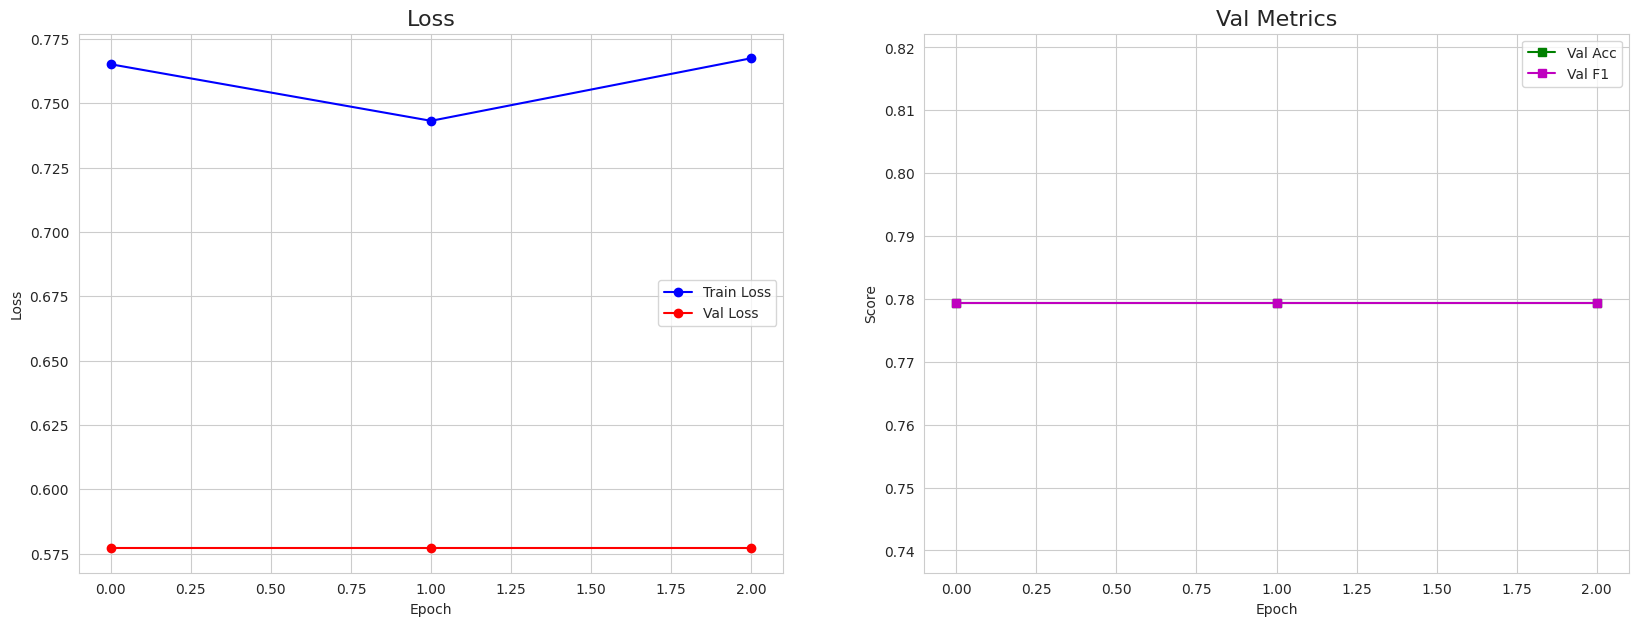

In [13]:
def plot_training_history(history):
    sns.set_style("whitegrid")
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,7))

    ax1.plot(history['train_loss'], 'b-o', label='Train Loss')
    ax1.plot(history['val_loss'], 'r-o', label='Val Loss')
    ax1.set_title('Loss', fontsize=16); ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss'); ax1.legend()

    ax2.plot(history['val_acc'], 'g-s', label='Val Acc')
    ax2.plot(history['val_f1'], 'm-s', label='Val F1')
    ax2.set_title('Val Metrics', fontsize=16); ax2.set_xlabel('Epoch'); ax2.set_ylabel('Score'); ax2.legend()

    plt.show()

plot_training_history(history)

Test-time inference & submission

In [14]:
class SentimentTestDataset(Dataset):
    def __init__(self, texts, tokenizer, max_len):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_len = max_len
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoding = self.tokenizer.encode_plus(
            text, add_special_tokens=True, max_length=self.max_len,
            padding='max_length', truncation=True, return_attention_mask=True, return_tensors='pt'
        )
        return {'input_ids': encoding['input_ids'].flatten(),
                'attention_mask': encoding['attention_mask'].flatten()}

test_dataset = SentimentTestDataset(test_data['fullText'].tolist(), tokenizer, MAX_LEN)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Load best model
model = AutoModelForSequenceClassification.from_pretrained(OUTPUT_DIR).to(device)
tokenizer = AutoTokenizer.from_pretrained(OUTPUT_DIR)
model.eval()

all_predictions = []
for batch in test_loader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        all_predictions.extend(preds.cpu().numpy())

# Convert 0-4 -> 1-5
submission_df = pd.DataFrame({'predicted': [p+1 for p in all_predictions]})
submission_df.to_csv('deberta_v3_submission.csv', index=False)
print("Submission saved: deberta_v3_submission.csv")

Submission saved: deberta_v3_submission.csv


In [ ]:
submission_df.shape

In [16]:
submission_df.value_counts()

,count
predicted,
5,5306
1,4483
3,3756
2,3270
4,3185


In [17]:
submission_df.to_csv("/content/drive/MyDrive/project2/q2_submission.csv")